In [1]:
import numpy as np
import healpy as hp
import matplotlib.pylab as plt
from astropy.io import fits
from astropy_healpix import uniq_to_level_ipix
from lsst.sims.utils import _healbin

In [3]:
def _hpid2RaDec(nside, hpids, nest=True):
    """
    Correct for healpy being silly and running dec from 0-180.

    Parameters
    ----------
    nside : int
        Must be a value of 2^N.
    hpids : np.array
        Array (or single value) of healpixel IDs.

    Returns
    -------
    raRet : float (or np.array)
        RA positions of the input healpixel IDs. In radians.
    decRet : float (or np.array)
        Dec positions of the input healpixel IDs. In radians.
    """

    lat, lon = hp.pix2ang(nside, hpids, nest=nest)
    decRet = np.pi / 2.0 - lat
    raRet = lon

    return raRet, decRet

In [4]:
hdu1 = fits.open('bayestar.fits')

In [5]:
hdu1.info()

Filename: bayestar.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     54   19200R x 5C   [K, D, D, D, D]   


In [6]:
hdu1[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  

In [7]:
hdu1[1].data['PROBDENSITY'].shape

(19200,)

In [8]:
hdu1[1].data

FITS_rec([ (                1066,   4.40625732e-15,    1.54324531,  294.61895733,   2.28497625e-05),
          (                1067,   1.00164350e-14,  297.46445755,  128.1997008 ,   9.53427001e-06),
          (                1071,   8.21981343e-15,  307.56524854,   54.21339042,   1.02526800e-05),
          ...,
          (             6886721,   5.17151184e+01,  677.00775265,  205.0531015 ,   1.99846669e-06),
          (             6886722,   5.20140450e+01,  686.14306725,  202.22785586,   1.95432113e-06),
          (             6886723,   5.04276345e+01,  681.21409693,  203.92403666,   1.97770956e-06)],
         dtype=(numpy.record, [('UNIQ', '>i8'), ('PROBDENSITY', '>f8'), ('DISTMU', '>f8'), ('DISTSIGMA', '>f8'), ('DISTNORM', '>f8')]))

In [10]:
hdu1[1].data['UNIQ']

array([   1066,    1067,    1071, ..., 6886721, 6886722, 6886723], dtype=uint64)

In [11]:
level, ipix = uniq_to_level_ipix(hdu1[1].data['UNIQ'])

In [12]:
level, ipix

(array([ 4,  4,  4, ..., 10, 10, 10]),
 array([     42,      43,      47, ..., 2692417, 2692418, 2692419]))

In [13]:
names = ['ra', 'dec', 'area']
locations = np.zeros(hdu1[1].data['UNIQ'].size, dtype=list(zip(names, [float,float, float])))

In [14]:
for lev in np.unique(level):
    good = np.where(level == lev)
    nside = 2**lev
    ra, dec = _hpid2RaDec(nside, ipix[good])
    locations['ra'][good] = ra
    locations['dec'][good] = dec
    locations['area'][good] = hp.nside2pixarea(nside)

In [15]:
locations

array([( 0.44178647,  0.33983691,   4.09061543e-03),
       ( 0.49087385,  0.38439677,   4.09061543e-03),
       ( 0.58904862,  0.47611906,   4.09061543e-03), ...,
       ( 3.82344711,  0.61802557,   9.98685409e-07),
       ( 3.82191313,  0.61802557,   9.98685409e-07),
       ( 3.82268012,  0.6188246 ,   9.98685409e-07)],
      dtype=[('ra', '<f8'), ('dec', '<f8'), ('area', '<f8')])

In [16]:
help(_hpid2RaDec)

Help on function _hpid2RaDec in module __main__:

_hpid2RaDec(nside, hpids, nest=True)
    Correct for healpy being silly and running dec from 0-180.
    
    Parameters
    ----------
    nside : int
        Must be a value of 2^N.
    hpids : np.array
        Array (or single value) of healpixel IDs.
    
    Returns
    -------
    raRet : float (or np.array)
        RA positions of the input healpixel IDs. In radians.
    decRet : float (or np.array)
        Dec positions of the input healpixel IDs. In radians.



In [17]:
nside_out = 128
result = _healbin(locations['ra'], locations['dec'],
                  values=hdu1[1].data['PROBDENSITY']*locations['area'], nside=nside_out, reduceFunc=np.sum)
good = np.where(result != hp.UNSEEN)
result[good] = result[good]/hp.nside2pixarea(nside_out)

In [18]:
np.sum(hdu1[1].data['PROBDENSITY']*locations['area']), np.sum(result[good]*hp.nside2pixarea(nside_out))

(1.0000000000000229, 1.0000000000000229)

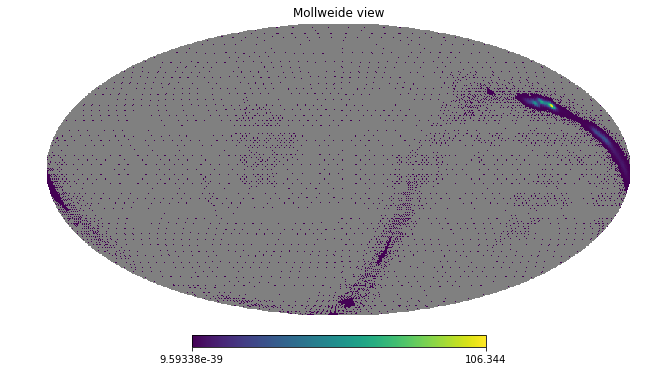

In [19]:
hp.mollview(result)

In [20]:
np.sum(hdu1[1].data['PROBDENSITY']*locations['area'])

1.0000000000000229

In [21]:
good = np.where(result != hp.UNSEEN)
np.sum(result[good])

15645.567525706037